In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from sklearn.datasets import make_blobs
from modAL.models import ActiveLearner

In [2]:
# query strategy for regression
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    return np.argmax(std)


# generating the data
X = np.random.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
y = np.sin(X) + np.random.normal(scale=0.3, size=X.shape)

# assembling initial training set
n_initial = 5
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_initial, y_initial = X[initial_idx], y[initial_idx]

# defining the kernel for the Gaussian process
# kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
#          + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# initializing the active learner
regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(),
    query_strategy=GP_regression_std,
    X_training=X_initial.reshape(-1, 1), y_training=y_initial.reshape(-1, 1)
)

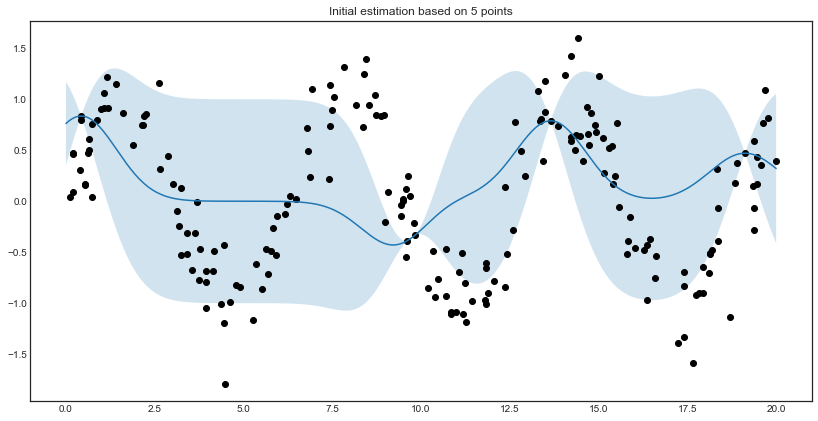

In [3]:
# plotting the initial estimation
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(0, 20, 1000)
    pred, std = regressor.predict(x.reshape(-1,1), return_std=True)
    plt.plot(x, pred)
    plt.fill_between(x, pred.reshape(-1, )-std, pred.reshape(-1, )+std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Initial estimation based on %d points' % n_initial)
    plt.show()

In [10]:
# active learning
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X)
    regressor.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))

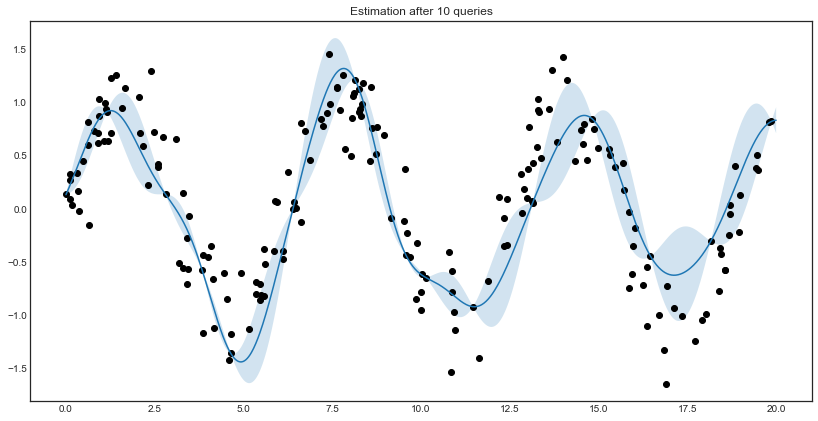

In [11]:
# plotting after active learning
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(0, 20, 1000)
    pred, std = regressor.predict(x.reshape(-1,1), return_std=True)
    plt.plot(x, pred)
    plt.fill_between(x, pred.reshape(-1, )-std, pred.reshape(-1, )+std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Estimation after %d queries' % n_queries)
    plt.show()